# Main

In [ ]:
%conda update -n base -c conda-forge conda
%conda update pip
%conda install --channel conda-forge pygraphviz
%pip install -r requirements.txt --upgrade

In [365]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

def hex_seq(n):
    # OEIS: A003215
    return 3*n*(n+1)+1

def optimization(A: np.array = None,
                 I: np.array = None,
                 K: np.array =  None,
                 gamma: np.float64 = None,
                 k_cap: np.float64 = None):
    for _ in range(50):
        lam = np.sum(K, axis = 0)
        lam_cap = np.diag(lam)
        diff = np.subtract(lam_cap, K)
        u, _, _ = np.linalg.svd(diff, I, hermitian = True)
        delta_u = np.subtract.outer(np.transpose(u),u)
        I_new = K * delta_u
        k_new = np.power(I_new, (-(gamma-2)))
        k = np.divide(k_new, k_cap)
    return k

def build_lats(N: int = 8,
               I_in: int = 1000,
               gamma: float = 0.5):

  G = nx.Graph(directed=False)
  G.add_node((0,0))
  for _ in range(N-1): 
      new_edges1 = [[(q, r), (    q, r - 1)] for (q, r) in G.nodes()]
      new_edges2 = [[(q, r), (q - 1,     r)] for (q, r) in G.nodes()]
      new_edges3 = [[(q, r), (q - 1, r + 1)] for (q, r) in G.nodes()]
      new_edges4 = [[(q, r), (    q, r + 1)] for (q, r) in G.nodes()]
      new_edges5 = [[(q, r), (q + 1, r - 1)] for (q, r) in G.nodes()]
      new_edges6 = [[(q, r), (q + 1,     r)] for (q, r) in G.nodes()]
      G.update(edges=new_edges1)
      G.update(edges=new_edges2) 
      G.update(edges=new_edges3)
      G.update(edges=new_edges4)
      G.update(edges=new_edges5)
      G.update(edges=new_edges6)

  for i in range(1, N-1):
      G.add_edge(( i, -7),  ( i+1,  -7))
      G.add_edge((-7,  i),  (  -7, i+1))
      G.add_edge((-i,  7), (-i-1,   7))

  for i in range(-(N-1), 0):
      G.add_edge(( i,  -7 - i), ( i+1,   -7-i-1))
      G.add_edge(( 7,     i  ), (   7,      i+1))
      G.add_edge((-i, -(-7-i)), (-i-1, -(-7-i-1)))

  n = hex_seq(N - 1)

  gamma_low = gamma
  gamma_cap = (2*gamma_low)/(gamma_low+1)

  k_seed = np.random.random(size=(n,n))

  i_0 = I_in

  A = np.array(nx.to_pandas_adjacency(G))

  I = np.array([i_0] + [-i_0/(A.shape[0]-1) for i in range(A.shape[0]-1)])

  k = np.multiply(A, k_seed)
  k_sym = (k + k.T)/2

  k = np.zeros_like(A)

  k[0,0] = 1

  k_cap = np.sum(k**gamma_low)**(1/gamma_low)

  A_opt = optimization(A, I, k_sym, gamma_cap, k_cap)

  G = nx.Graph(A_opt)

  return G, A_opt

In [ ]:
import matplotlib as mpl
mpl.rc('font',
       family = 'serif',
       serif = 'cmr10')
mpl.rc('mathtext',
       fontset = 'cm')

G_hex, A_optimized = build_lats(8, 1000, 0.5)
G_hex_2, A_optimized_2 = build_lats(8, 1000, 2)

weights = np.array([G_hex.get_edge_data(u, v)['weight'] for u, v in G_hex.edges])
weights_2 = np.array([G_hex_2.get_edge_data(u, v)['weight'] for u, v in G_hex_2.edges])

x = np.linspace(0, 8, len(G_hex.nodes))
pos_dict = {i: (i, x[i]) for i in range(len(list(G_hex.nodes())))}
nx.set_node_attributes(G_hex, pos_dict, 'pos')
nx.set_node_attributes(G_hex_2, pos_dict, 'pos')

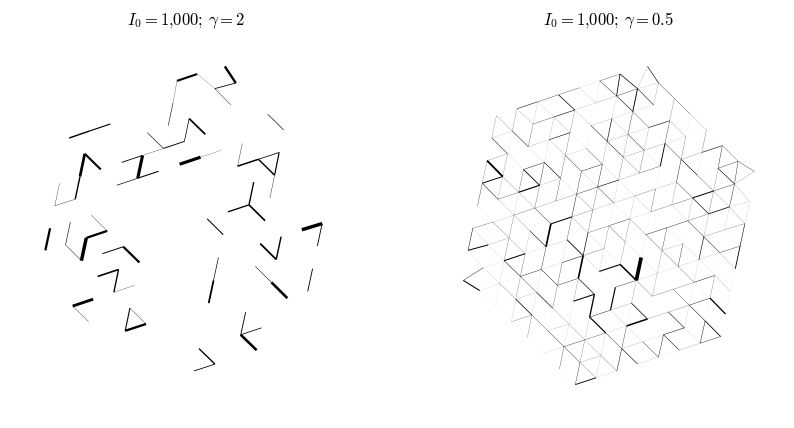

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

nx.draw_networkx_edges(G = G_hex_2,
                       pos = nx.nx_agraph.graphviz_layout(G_hex_2, prog="neato"),
                       ax = ax1,
                       edge_cmap = plt.cm.magma,
                       edge_color = 'k',
                       width = 10*weights_2)

nx.draw_networkx_edges(G = G_hex,
                       pos = nx.nx_agraph.graphviz_layout(G_hex, prog="neato"),
                       ax = ax2,
                       edge_cmap = plt.cm.magma,
                       edge_color = 'k',
                       width = 10*weights)

ax1.axis("off")
ax1.set_title(r'$I_0 = $1,000; $\gamma = 2$')
ax2.axis("off")
ax2.set_title(r'$I_0 = $1,000; $\gamma = 0.5$')
plt.show()

# Assignment

Reproduce Bohn and Magnasco's Figs. 2a and 2b:

Steps are given below but please read through the paper to understand how they set things up.

The full team is encouraged to work together on Teams.

I check the paper again and that constraint on conductances can be viewed as a constraint on building material for the network

Everything derives from a Lagrange multiplier set up and has parallels with the HOT model, size-area density, and the (erroneous) West et al. work for blood networks.

Construct an adjacency matrix $\displaystyle{\mathbf{A}}$ representing the hexagonal lattice
used in  Plot this adjacency matrix.


Run a minimization procedure to construct Figs. 2a and 2b which correspond to $\gamma=2$ and $\gamma=1/2$.

Steps:

Set each link's length to 1 (the $d_{kl}$).
The goal then reduces to minimizing the cost

$$
C 
= 
\sum_{k,l} 
\left| 
I_{kl}
\right|^{\Gamma}
$$
where $I_{kl}$ is the current on link $kl$
and $\Gamma = 2\gamma/(\gamma+1)$.

Place a current source of nominal size $i_0$ at one node
(as indicated in Fig.~2 above).

All other nodes are sinks, drawing a current of 
$$
i_{k} = 
- \frac{i_{0}}
{N_{\text{nodes} - 1}}.
$$

Suggest setting $i_0 = 1000$ (arbitrary but useful value given the size of the network).

Generate an initial set of random conductances for each link, the $\{\kappa_{kl}\}$. From the paper, these must sum to some global constraint as:

$$
K
=
\left(
\sum_{k,l}
\kappa_{kl}^{\gamma}
\right)^{1/\gamma}.
$$

This constraint is meant to represent a limitation on the amount of material that can be used to build the network.

Note: There seems to be no reason not to set $K = 1$.
However, taking the initial value of $K$ determined by the initial set of random conductances would work.

To our notational peril, we now have a lot of $k$ types on deck.

Solve the following to determine the potential $U$ at each node,
and hence the current on each link using:

$$
i_{k}
=
\sum_{l}
\kappa_{kl}(U_{k}-U_{l}),
$$

and then

$$
I_{kl} = \kappa_{kl}(U_{l} - U_{k}).
$$

Note: the paper erroneously has $I_{kl} = R_{kl}(U_{l} - U_{k})$ below
equation 4; there are a few other instances of similar
miswritings of $R_{kl}$ instead of $\kappa_{kl}$.

Now, use scaling in equation (10) to compute a new set of $\{\kappa_{kl}\}$ from the $I_{kl}$.

Everything boils down to:

$$
\kappa_{kl} \propto | I_{kl} |^{-(\Gamma-2)},
$$

where the constant of proportionality is determined by again making sure that 

$$
K^{\gamma}
=
\sum_{k,l}
\kappa_{kl}^{\gamma}.
$$

Antioch joke:

Bonus: Please see reference 1 in for a random connection to the next assignment's code name.

Some help---Let's sort out the key equation:

$$
i_{k}
=
\sum_{l}
\kappa_{kl}(U_{k}-U_{l}).
$$

Each time we loop around through this equation, we know the $i_{k}$ and the $\kappa_{kl}$ and must determine the $U_{k}$. In matrixology, we love $\displaystyle{\mathbf{A} \vec{x} = \vec{b}}$ problems so let's see if we can fashion one:

$$
i_{k}
=
\sum_{l}
\kappa_{kl}(U_{k}-U_{l})
$$

$$
=
\sum_{l}
\kappa_{kl} U_{k}
-
\sum_{l}
\kappa_{kl} U_{l}
$$

$$
=
U_{k}
\sum_{l}
\kappa_{kl}
-
\sum_{l}
\mathbf{K}_{kl} U_{l}
$$

$$
=
\lambda_{k}
U_{k}
-
[
  \mathbf{K} \vec{U}
]_k
$$

where we have set
$\displaystyle{\lambda_{k}=\sum_{l}\kappa_{kl}}$, 
the sum of the $k$ th row of the matrix $\mathbf{K}$.
We now construct a diagonal matrix $\Lambda$ with
the $\lambda_{k}$ on the diagonal, and obtain:

$$
\vec{i}
=
\left(
\Lambda
- 
\mathbf{K}
\right)
\vec{U}.
$$

The above is in the form $\displaystyle{\mathbf{A}\vec{x}=\vec{b}}$ so we can solve for $\displaystyle{\vec{U}}$ using standard features of R, Matlab, Python, ... (hopefully).

## TRIAL

### Starting Work

$$
\mathbf{K}_{kl} = \kappa_{kl}
$$

If $k$ is adjacent to $l$, and 
$\mathbf{K}_{kl} = 0$ otherwise.
We can then use $\mathbf{K}$ to compute the diagonal matrix $\Lambda$, where:

$$
\Lambda_{kk} =
\lambda_k =
\sum_l \kappa_{kl}
$$

$$
\vec{i}
=
\left(
\Lambda
-
\mathbf{K}
\right)
\vec{U}
$$

To solve for $\vec{U}$, we can rearrange the equation $\vec{i} = (\Lambda - \mathbf{K}) \vec{U}$ as $\vec{U} = (\Lambda - \mathbf{K})^{-1} \vec{i}$, assuming that $\left(\Lambda - \mathbf{K}\right)$ is invertible. Since this matrix is not diagonalizable using the traditional eigenvalue decomposition, we will use Gaussian elimination instead.

$
\mathbf{M=U\Sigma V^*}
$

Once we have the node potentials $\vec{U}$, we can compute the currents on each link using $i_{kl} = \kappa_{kl} (U_k - U_l)$.


In [ ]:
import networkx as nx
import pygraphviz
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.simplefilter("ignore")

def hex_seq(n):
    # OEIS: A003215
    return 3*n*(n+1)+1

def optimization(I: np.array, k:np.array, gamma_cap: float,
                 k_cap:float):
    for _ in range(50):
        lam = np.sum(k, axis=0)
        lam_cap = np.diag(lam)
        diff = lam_cap - k
        u,_,_ = np.linalg.svd(diff, I, hermitian = True)
        delta_u = np.subtract.outer(np.transpose(u),u)
        I_new = k*delta_u
        k_new = np.power(np.abs(I_new), (-(gamma_cap-2)))
        k = np.divide(k_new, k_cap)
    return k

def initialize_K(A: np.ndarray = None,
                 K_rnd: np.ndarray = None,
                 kappa_0: np.float64 = None):
    for i in A[-1, :]:
        if i != 0:
            # print(i)
            kappa_0[-1,int(i)] = 1
            return K_rnd if kappa_0.shape != A.shape else kappa_0

def build_lats(N: int = 8,
               I_in: int = 1000,
               gamma: float = None):

    G = nx.Graph(directed=False)
    G.add_node((0,0))
    for _ in range(N-1): # a(n) is for n + 1 triangles that intersect
        new_edges1 = [[(q, r), (    q, r - 1)] for (q, r) in G.nodes()]
        new_edges2 = [[(q, r), (q - 1,     r)] for (q, r) in G.nodes()]
        new_edges3 = [[(q, r), (q - 1, r + 1)] for (q, r) in G.nodes()]
        new_edges4 = [[(q, r), (    q, r + 1)] for (q, r) in G.nodes()]
        new_edges5 = [[(q, r), (q + 1, r - 1)] for (q, r) in G.nodes()]
        new_edges6 = [[(q, r), (q + 1,     r)] for (q, r) in G.nodes()]
        G.update(edges=new_edges1)
        G.update(edges=new_edges2) 
        G.update(edges=new_edges3)
        G.update(edges=new_edges4)
        G.update(edges=new_edges5)
        G.update(edges=new_edges6)

    for i in range(1, N-1):
        G.add_edge(( i, -7),  ( i+1,  -7))
        G.add_edge((-7,  i),  (  -7, i+1))
        G.add_edge((-i,  7), (-i-1,   7))

    for i in range(-(N-1), 0):
        G.add_edge(( i,  -7 - i), ( i+1,   -7-i-1))
        G.add_edge(( 7,     i  ), (   7,      i+1))
        G.add_edge((-i, -(-7-i)), (-i-1, -(-7-i-1)))

    n = hex_seq(N - 1)

    if gamma is None:
      gamma = 2

    gamma_cap = (2*gamma)/(gamma+1)

    k_seed = np.random.random(size=(n,n))

    i_0 = I_in

    A = np.array(nx.to_pandas_adjacency(G))

    I = np.array([i_0] + [-i_0/(A.shape[0]-1) for _ in range(A.shape[0]-1)])

    k = np.multiply(A, k_seed)
    K_sym = (k + k.T)/2

    K = initialize_K(A, K_sym, k)

    K[0,0] = 1

    k_cap = np.sum(k**gamma_cap)**(1/gamma_cap)

    A_opt = optimization(I, K, gamma_cap, k_cap)

    G = nx.Graph(A_opt)
    num_nodes = len(G.nodes())

    x = np.linspace(0, 8, num_nodes)

    pos_dict = {i: (i, x[i]) for i in range(len(list(G.nodes())))}
    nx.set_node_attributes(G, pos_dict, 'pos')

    pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

    weights = np.geomspace(9+(2/3),1,len(list(G.edges)))
    nx.set_edge_attributes(G, values = weights, name = 'weight')

    fig, ax1 = plt.subplots(1,1,figsize=(10,10))

    nx.draw_networkx_edges(
        G = G,
        pos = pos,
        ax = ax1,
        edge_cmap = plt.cm.magma,
        edge_color = weights,
        width = weights)
    ax1.axis("off")
    fig.suptitle(r'$I_0 = $'f'{i_0}\n'r'$\gamma = $'f'{gamma}')
    plt.show()
    return G, A_opt

In [192]:
def optimization(A: np.array = None,
                 I: np.array = None,
                 K: np.array =  None,
                 gamma: np.float64 = None,
                 k_cap: np.float64 = None):
    for _ in range(6):
        lam = np.sum(K, axis = 0)
        # print(f'Lambda: {len(lam)}') # -> (169, 169)
        lam_cap = np.diag(lam)
        # print(f'Lambda: {len(lam_cap)}') # -> (169, 169)
        diff = np.subtract(lam_cap, K) 
        # Not invertible -> singular -> !C.F.G.
        """
        # print(diff) # -> (8, 8)
        # u, _, _ = np.linalg.svd(K, full_matrices=True)
        # print(u.shape, s.shape, vh.shape)
        # print(np.allclose(I, np.dot(u[:, :6] * s, vh)))
        # smat = np.zeros((9, 6), dtype=complex)
        # smat[:6, :6] = np.diag(s)
        # print(np.allclose(I, np.dot(u, np.dot(smat, vh))))
        # u = np.linalg.solve(diff, I) # -> (8), (169)!!!!
        """
        u, _, _ = np.linalg.svd(diff, I, hermitian = True)
        delta_u = np.subtract.outer(np.transpose(u),u)
        I_new = np.dot(K, delta_u)
        print(I_new)
        k_new = np.power(I_new, (-(gamma-2))) # Failure to converge
        # k_new = np.sqrt(2*np.pi*len(I.shape[0])*(I.shape[0]/np.e))**I.shape[0]
        k = np.divide(k_new, k_cap)
    """
        # u, s, vh = np.linalg.svd(I, full_matrices=True)
        # print(u.shape, s.shape, vh.shape)
        # print(np.allclose(I, np.dot(u[:, :6] * s, vh)))
        # smat = np.zeros((9, 6), dtype=complex)
        # smat[:6, :6] = np.diag(s)
        # print(np.allclose(I, np.dot(u, np.dot(smat, vh))))
    # return u
    """
    return K

def initialize_K(A: np.ndarray = None,
                 K_rnd: np.ndarray = None,
                 kappa_0: np.float64 = None):
    for i in A[-1, :]:
        if i != 0:
            # print(i)
            kappa_0[-1,int(i)] = 1
            return K_rnd if kappa_0.shape != A.shape else kappa_0
        
def trial_two(gamma_low = 0.5, i_0 = 1000, n = 8):
    gamma_cap = (2*gamma_low)/(gamma_low+1),
    
    G = nx.hexagonal_lattice_graph(n, n)
    A = np.array(nx.to_pandas_adjacency(G))
    k_rnd = np.random.random(size=(A.shape))
    I = np.array([i_0] + [-i_0/(A.shape[0]-1) for _ in range(A.shape[0]-1)])

    k = np.multiply(A, k_rnd)
    k_sym = (k + k.T)/2
    kappa = np.sum(k ** gamma_low) ** (1/gamma_low)
    A_opt = optimization(A, I, k_sym, gamma_cap, kappa)

    G = nx.Graph(A_opt)
    num_nodes = len(G.nodes())

    x = np.linspace(0, 8, num_nodes)

    pos_dict = {i: (i, x[i]) for i in range(len(list(G.nodes())))}
    nx.set_node_attributes(G, pos_dict, 'pos')

    pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

    weights = np.geomspace(9+(2/3),1,len(list(G.edges)))
    nx.set_edge_attributes(G, values = weights, name = 'weight')

    fig, ax1 = plt.subplots(1,1,figsize=(10,10))

    nx.draw_networkx_edges(
        G = G,
        pos = pos,
        ax = ax1,
        edge_cmap = plt.cm.magma,
        edge_color = weights,
        width = weights)
    ax1.axis("off")
    fig.suptitle(r'$I_0 = $'f'{i_0}\n'r'$\gamma = $'f'{gamma_cap}')
    plt.show()
    return G, A_opt

## ERROR

In [ ]:
def trial_and_error(n_in: int = 10,
                    I_in: np.float64 = 1000.0,
                    gamma: np.float64 = None,
                    show_plot: bool = False):
    from math import comb
    """ 
    @Function:
    Desc:  This function is for testing different layouts,
           orientations, perspectives, for variable input.
    
    @Params:
    n: int
        Def:  Field size (integer valued)

        Desc: This will set the scope of the matrices

    I_in: np.float64
        Def:  Initial impedance measure

        Desc: This will set the resistance to flow in the field
              Should be proportional to the number of terminal points
              That is, for *any* stable system, the total energy in
              is equal to the total energy out.
              Think of Pascal, Murray, Hagen, Poiseuille, Newton, et. al.

    gamma: np.float64
        Def:   Exponent for abs(I_{kl})
               where kl is a link / edge in the field

        Desc:  The scale of the cost function to be minimized

    @ Returns:
    G: nx.Graph
        Desc:  Graphical display of the output using NetworkX
    
    I: np.ndarray
        Desc:  Matrix of the impedance on the field
    """
    if n_in % 2 != 0:
        to_user = "Try using something even, otherwise it's just odd..."
        return print(to_user)

    """
    # Initial impedance measure
    """
    i_0 = I_in

    # Initial Graph: empty field
    G = nx.Graph(directed=True)

    # Initial Size: integer valued
    # OEIS: A003215 -> size of the field
    size = hex_seq(n_in - 1) 

    # 
    n = n_in

    # Initial Energy: impedance
    i_0 = I_in

    """
    # Initial Matrix: empty field
    """
    M = np.zeros((size, size))
    # print(f'M: {M.shape}')

    """
    # Initialize K:
    # Random conductances on the field
    # Lets try distributing binomially...
    # Kappa = np.random.binomial(size=(n, n))
    """
    K_rnd = np.random.random(size=(size, size))
    # print(f'K_rnd: {K_rnd.shape}')

    """
    # Build the field.
    # We want to identify
    # the locations in the field
    # where the nodes can conduct energy.
    # Or using other words $cdots$
    # which nodes resonate?
    # 
    # The word length of the
    # in-line comments above should
    # get us going in a direction
    # 
    # We want to create 3 orthogonal 
    # directions i.e. a 3-dimensional
    # field represented in 2-dimensions
    # which requires 6 pairwise combinations
    # In this case, the allocation of nodes
    # should follow a binomial distribution
    # equally partitioning the field.
    #
    #*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
    #*#         WARNING         #*#
    #*#*#*#*#*#*#*#*#*#*#*#*#*#*#*#
    #
    # This may require the use of
    # a little imagination to work 
    # just right, we'll see.
    #
    # There is a reason that Disney^{TM}
    # chose to name Rapunzel's chameleon
    # Pascal in the movie Tangled^{(R)}.
    # ...
    # ...
    # ...
    # Because, trial *and* error
    # both contribute to progress
    #
    # M[ 0 , 1: ] = 1
    # M[ 1:, 0  ] = 0
    # M[n-1,  : ] = 0
    # M[  :, n-1] = 0
    #
    # Maybe we should use a little imagination
    # Or use a mechanical counting machine of some sort...
    # https://en.wikipedia.org/wiki/Pascal%27s_calculator
    """
    for x in range(size):          # Iterate through the field
        i = x                 # row ... n
        j = x - 1             # col ... n-1
        if j == -1:                
            j = 0
        j = max(j, 0)         # except column 0
        val = comb(i,j)       # for all combinations (i,j)
        if val < 0:                # If the value is negative
            val = np.abs(val)
        if val % 2 == 0:           # If a node is even valued... 
            M[   i ,    j ] = 1    # Diagonal: TL -> BR
            M[  -i ,    j ] = 1    # Diagonal: BL -> TR
            M[  -i,    -j ] = 1    # Diagonal: BL -> TR
            M[   i ,   -j ] = 1    # Diagonal: TR -> BL

    """
    # and for the final two/thirds
    """
    mid = n // 2

    M[mid, :]   = 1
    M[:, mid]   = 1

    """
    # Everything needs a center
    """
    M[mid, mid] = 0
    # print(f'M: {M.shape}')

    # NetworkX has a way...because everything is faster if it has a base
    G = nx.hexagonal_lattice_graph(n, n)

    # Save for educational purposes
    G_matrix = nx.from_numpy_array(M, parallel_edges=False, create_using=None)

    """
    # Adjacency matrix for the field.
    # link      = 1
    # otherwise = 0
    """

    K_rnd = np.random.random(size=(size, size))
    G = nx.hexagonal_lattice_graph(n, n)
    A = np.array(nx.to_pandas_adjacency(G))
    I = np.array([i_0] + [-i_0 / (n - 1) for _ in range(n - 1)])
    A_dot_K = np.multiply(A, K_rnd)
    K_0 = np.ones_like(A_dot_K)
    K_0 = initialize_K(A, K_rnd, K_0)
    kappa = np.sum(K_0 ** gamma) ** (1/gamma)
    A_opt = optimization(I, K_rnd, gamma, kappa)
    # print(f'A: {A.shape}')

    """
    # Impedance matrix for the field
    # Input  =  i_0 (or  I_in) e.g. push
    # Output = -i_0 (or I_out) e.g. pull
    """
    I = np.array([i_0] + [-i_0 / (n - 1) for _ in range(n - 1)])

    """
    Distribute the random conductivity to the links
    """
    A_dot_K = np.multiply(A, K_rnd)

    """
    Is it symmetric?
    Progress        if  True
    Trial and Error if  False
    """
    try:
        K_0 = (A_dot_K + A_dot_K.T) / 2
        if np.sum(A_dot_K.T == A_dot_K) == n ** 2 is False:
            return print('An error has occurred in distributing the conductances.'), A_dot_K

    except Exception:
        return print('Asymmetric conductivity on the field.'), A_dot_K, A_dot_K.T

    K_0 = np.ones_like(A_dot_K)

    """
    # We want to set as the 'bottom left' node
    # or transform the final array to orient
    # appropriately using linear transformations
    # to maintain the appropriate perspective
    # Thinking of bottom left, then we would want
    # [bottom, first non-zero element]
    # def initialize_kappa(Adj: np.ndarray = None)
    # for i in A[-1, :]:
    #   if i != 0:
    #      return kappa_0[-1,i] = 1
    """
    K_0 = initialize_K(A, K_rnd, K_0)
    # print(f'K_0: {K_0.shape}\n {K_0}')

    kappa = np.sum(K_0 ** gamma) ** (1/gamma)

    A_opt = optimization(I, K_rnd, gamma, kappa)

    G = nx.from_numpy_array(A_opt, 
                            create_using = nx.hexagonal_lattice_graph(
                                    n = A_opt.shape[0], 
                                    m = A_opt.shape[1], 
                                    create_using = nx.Graph(directed = True))
        )

    weights = np.linspace(
        10 + (2/3),        # Minimum
        0.01,              # Maximum
        len(list(G.edges)) # Step
        )
    nx.set_edge_attributes(G, values = weights, name = 'weight')

    fig, ax1 = plt.subplots(1,1)

    pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

    # Hexagonal
    nx.draw_networkx_edges(G = G,
                           pos = pos,
                           ax = ax1,
                           edge_color = 'k',
                           alpha = 0.95,
                           width = weights)

    ax1.axis("off")

    ax1.set_title(r'$I_0 = $'f'{i_0}')
    return ax1 if show_plot else (G, I, ax1)

```
def gen_fun(n: int = 8):
  """
  Generates the centered hexagonal number for iteration n
  Which coincides with hexagon of side length n
  and satisfies the following:
  H(n + 1) = H(n) + 6n
      H(n) = n^3 - (n-1)^3
           = 3n(n-1) + 1
           = 3n^2 - 3n + 1
           = 1 + 6 (n(n-1) / 2)
  Giving the coincidence:
    center = (3 + (12H - 3) / 6)
  Which is the index of the central node for lattice H with size H(n).
  """
  n = int(n)
  return [3*n*(n+1)+1 for n in range(n)]

def binomial_generator(n: int = 1,
                       p: float = 0.5):
  from numpy.random import Generator
  return Generator.binomial(n = n,
                            p = p,
                            size = n+1)

def change_pos(k: np.float64 = 1.0, 
               theta: np.float64 = np.pi/2,
               pos = None):
    warnings.filterwarnings(action='once')
    XY = np.array([v for k, v in pos.items()])
    scale = k
    kXY = scale*XY
    rotation = np.array([
        [np.cos(theta),np.sin(theta)],
        [-np.sin(theta),np.cos(theta)]])
    for i in range(len(pos.items())):
      pos[i] = ((rotation @ kXY[i].flatten()) for i in kXY.flatten())
    return pos

def plot_lattice(n:int = 8, X = None):
  warnings.filterwarnings(action  = 'ignore')
  sequence_at_n: dict = {}
  if X is None:
    X: list[int] = gen_fun(n)
    for i in range(n):
      sequence_at_n[i] = nx.utils.discrete_sequence(n, distribution = X)

  G = nx.hexagonal_lattice_graph(n, n,
                               periodic = False,
                               with_positions = True,
                               create_using = nx.MultiGraph())

  gradient = np.linspace(0,360,len(list(G.nodes())))

  pos = nx.nx_agraph.graphviz_layout(G,prog="neato")

  pos = change_pos(k = 100,
                   theta = np.pi/4,
                   pos = pos)

  gradient = np.linspace(1,360,len(list(G.nodes())))

  fig, ax = plt.subplots(1,1,figsize=(10,10))

  nx.draw_networkx_nodes(
      G=G,
      pos=pos,
      ax=ax,
      node_size=0.1,
      node_shape='h',
      node_color=gradient,
      alpha=1,
      edgecolors=None,
  )
  nx.draw_networkx_edges(G,
                         pos = pos,
                         ax = ax,
                         arrows = None,
                         edge_cmap = 'viridis',
                         edge_vmin = 0,
                         edge_vmax = 1,
                         alpha = 0.5,
                         width = 0.15)
  plt.axis("off")
  plt.show()
  return G
  ```

### Save for Later?

```
G = plot_lattice(8)
def big_lats(n: int = 8):
  edge_list = {}
  for i in range(n):
    if i%3 == 0:
      edge_list[i] = (i+1, i+2, i+3)
    edge_list[i] = (i+1, i+2) if i%2 == 0 else (i+2, i+4)
  G = plot_lattice(n)

  pos = nx.nx_agraph.graphviz_layout(G,
                                     prog="neato")

  gradient = np.linspace(1,360,len(list(G.nodes())))

  fig, ax = plt.subplots(1,1, figsize=(10,10))

  nx.draw_networkx_nodes(G = G,
                        pos = pos,
                        ax = ax,
                        node_size = 0.1,
                        node_shape = 'h',
                        node_color = 'k',
                        alpha = 2/3,
                        edgecolors = None)
  nx.draw_networkx_edges(G,
                        pos = pos,
                        ax = ax,
                        arrows = None,
                        edge_cmap = 'viridis',
                        edge_vmin = 1,
                        edge_vmax = 360,
                        alpha = 0.5,
                        width = 0.15)
  plt.axis("off")
  plt.show()
  return G
big_lats(50)
G_adj_df = nx.to_pandas_adjacency(G)
G_adj_df.replace(0.0, np.nan)

from math import comb

""" 
@Params:
n:
  Def:  Field size (integer valued)

  Desc: This will set the scope of the matrices

I_in:
  Def:  Initial impedance measure

  Desc: This will set the resistance to flow in the field
        Should be proportional to the number of terminal points
        That is, for *any* stable system, the total energy in
        is equal to the total energy out.
        Think of Pascal, Murray, Hagen, Poiseuille, Newton, et. al.
"""
n = 10
I_in = 1000

M = np.zeros((n,n))

for x in range(n):
    i = x
    j = x - 1
    j = max(j, 0)
    val = comb(i,j)
    if val % 2 == 0:
      M[   i ,    j ] = 1
      M[  -i ,    j ] = 1
      M[-(-i), -(-j)] = 1
      M[   i ,   -j ] = 1
      M[   i,     i ] = 1
      M[   j,     j ] = 1

M[n // 2, :] = 1
M[:, n // 2] = 1

# M[0,1:] = 1
# M[1:,0] = 0
# M[n-1,:] = 0
# M[:,n-1] = 0

n_0 = hex_seq(n - 1)

gamma_low = .5
gamma_cap = (2*gamma_low)/(gamma_low+1)

k_seed = np.random.random(size=(n,n))

i_0 = I_in

A = np.array(nx.to_pandas_adjacency(G))

I = np.array([i_0] + [-i_0/(A.shape[0]-1) for i in range(A.shape[0]-1)])

k_0 = np.multiply(A, k_seed)
k_sym = (k_0 + k_0.T)/2

"""
# print(np.sum(k_sym.T==k_sym) == n**2)
# True
"""
k = np.zeros_like(A)

"""
# We want to set as the 'bottom left' node
# or transform the final array to orient
# appropriately using linear transformations
# to maintain the appropriate perspective
"""
k[0,0] = 1 

kappa = np.sum(k**gamma_low)**(1/gamma_low)

A_opt = optimization(A, I, k_sym, gamma_cap, kappa)

G = nx.Graph(A_opt)

weights = np.geomspace(9+(2/3),1,len(list(G.edges)))
nx.set_edge_attributes(G, values = weights, name = 'weight')

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

pos = [
             # Should give hexagonal layout of graph
             nx.nx_agraph.graphviz_layout(G, prog="neato"),
             # Should give vertical layout of graph
             nx.nx_agraph.graphviz_layout(G, prog="dot")
            ]

nx.draw_networkx_edges(G = G,
                    pos = pos[0],
                    ax = ax1,
                    edge_color = 'k',
                    alpha = 1,
                    width = weights)

nx.draw_networkx_edges(G = G,
                    pos = pos[1],
                    ax = ax2,
                    edge_color = 'k',
                    alpha = 1,
                    width = weights)

ax1.axis("off")
ax2.axis("off")

fig.suptitle(r'$I_0 = $'f'{i_0}\n'r'$n = $'f'{n}')

plt.show()
n = 360 #@param {type:'slider', min:1, max:10000, step:1}
M, c = gen_fun(n)
G = plot_lattice(M)

edges = list(G.edges())
list(G.edges(1, data=True))[2]
x = np.arange(8)
x = x[1:,np.newaxis] + x[np.newaxis,:]
c_1 = x[x % 2 == 0]
c_2 = x[x % 3 == 0]
c_3 = x[x % 4 == 0]
c_4 = x[x % 5 == 0]
print(c_1)
print(c_2)
print(c_3)
print(c_4)
A= gen_fun(10)
Mg = nx.from_numpy_array(A, parallel_edges=False, create_using=None)

Mg.add_edge(0,1)
Mg.add_edge(0,9)
Mg.add_edge(2,9)
Mg.add_edge(5,0)
Mg.add_edge(9,8)

Mg.remove_edge(5,1)
Mg.remove_edge(5,2)
Mg.remove_edge(5,3)
Mg.remove_edge(5,5)
Mg.remove_edge(5,7)
Mg.remove_edge(5,8)

# Mg.add_edge(0,2)
# Mg.add_edge(0,3)
# Mg.add_edge(0,4)
# Mg.add_edge(0,6)
# Mg.add_edge(0,7)
# Mg.add_edge(0,8)
# Mg.add_edge(5,9)

nx.draw_circular(Mg, with_labels=True)
adj_m = nx.adjacency_matrix(Mg)
Matrix = adj_m.toarray()
n = 15
l = math.ceil(n / 2)

edg = math.floor(n/3)

A = np.zeros((n+1,n+1), int)
A[0, edg:-edg] = 1
A[edg:-edg, 0] = 1
A[edg:-edg, -1] = 1
A[-1, edg:-edg] = 1
for i in range(1,n+1):
    for j in range(1,n+1):
        if (i+j) % 5 == 0:
            A[i,j] = 1

print(A)
# for i in range(1, int(n / 2), 1):
#   new = np.ones_like(A)
#   new = np.pad(new, (i+1,), 'constant', constant_values = 0)
#   print(new)


n = Matrix.shape[1]
c = np.array([1 + 6 * (c * (c - 1) / 2) for c in range(n)])

fig, ax = plt.subplots(1,1,figsize=(10,10))

G = nx.MultiGraph(Matrix)
G.add_edges_from(((7,8), (7,6), (4,3), (2,3)))

pos = nx.circular_layout(G)

# Maintaining closed and stable system
# Stable iff lhs of sum equals rhs of sum e.g. 0 = ...
#
# Case 1:
# d l_0 r_0^2 = (cos(x) * d l_0 r_1^2) + (cos(y) * d l_0 r_2^2)
# flow_in = np.cos([x]) + np.cos([y])
#
# Case 2: 
# d l_1 r_1^2 = -cos(x+y) * d l_1 r_1^2) + (cos(x) * d l_1 r_2^2)
# flow_in = -np.cos([x+y]) + np.cos([x])
#
# Case 3: 
# d l_2 r_2^2 = -(cos(x+y) * d l_2 r_1^2) + (cos(y) * d l_2 r_0^2)
# flow_in = -np.cos([x+y]) + np.cos([y])
#
# Case 4:
# d l_0 r_0^2 = 2(cos(x) * d l_0 r_1^2) + (1 * d l_0 r_2^2)
# 
# [  M  ] @   z   =  0
#
# [      1  , cos( x ),  cos( y )]   [z_1]
# [ cos( x ),      1  , -cos(x+y)] = [z_2]
# [-cos(x+y), cos( y ),       1  ]   [z_3]
# 
# [cos(x) = r_0^2 - (r_0^3 - 2*r_1^3)^(2/3) / 2 * r_1^2]

r_0 = 1
r_1 = np.imag(1 / 2 ** (-3))
r_2 = np.imag(1 / 2 ** (-3))

triads = {
"01": [      ],
"02": [(1, 2)],
"03": [(1, 2), 
       (2, 1)],
"04": [(3, 1), 
       (3, 2)],
"05": [(1, 3), 
       (2, 3)],
"06": [(1, 3), 
       (3, 2)],
"07": [(1, 2), 
       (2, 1), 
       (3, 1)],
"08": [(1, 2), 
       (2, 1), 
       (1, 3)],
"09": [(1, 2), 
       (3, 2), 
       (1, 3)],
"10": [(1, 3), 
       (3, 2), 
       (2, 1)],
"11": [(1, 2), 
       (2, 1), 
       (3, 1), 
       (1, 3)],
"12": [(1, 2), 
       (2, 1), 
       (3, 1), 
       (3, 2)],
"13": [(1, 2), 
       (2, 1), 
       (1, 3), 
       (2, 3)],
"14": [(1, 2), 
       (2, 1), 
       (1, 3), 
       (3, 2)],
"15": [(1, 2), 
       (2, 1), 
       (1, 3), 
       (3, 2), 
       (2, 3)],
"16": [(1, 2),
       (2, 1), 
       (2, 3), 
       (3, 2), 
       (1, 3), 
       (3, 1)]
}
G.edges.data('center',   default=c[-1])
G.edges.data('x-length', default = 1)
G.edges.data('y-length', default = 1)
G.edges.data('z-length', default = 1)
G.edges.data('r_0', default = r_0)
G.edges.data('r_1', default = r_1)
G.edges.data('r_2', default = r_2)

G.nodes.data('r_0', default = r_0)
G.nodes.data('r_1', default = r_1)
G.nodes.data('r_2', default = r_2)

edges = list(G.edges())

# print(list(G.edges(data=True)))

r_0 = nx.get_node_attributes(G, 'r_0')
r_1 = nx.get_node_attributes(G, 'r_1')
r_2 = nx.get_node_attributes(G, 'r_2')

# for j in range(1, n + 1, 1):
#   r_t = list(G.edges(j))
#   r_t_0 = r_0[j]
#   r_t_1 = r_1[j]
#   r_t_2 = r_2[j]
#   x = j + 1
#   y = j
#   if y <= 1:
#     y = 0
#   else:
#     for i in np.random.binomial(j - 1, 0.5, size = n):
#       if i < 2/3:
#         angle = np.arccos((      r_1**3 + r_2**3)**(4/3) - 
#                             (    r_1**4 - r_2**4)        /
#                             (2 * r_1**2 * r_2**2)        )
#       else:
#         angle = np.arccos(r_0**2 - (r_0**3 - 2 * r_1**3))
#       print(angle)
       # nx.set_edge_attributes(G.edges(n),
       #                        angle,
       #                        'angle')

# ang_list = [d for _, _, d in list(G.edges(data=True))][0]
# print(ang_list)  
i_0 = 10**3
default_sink = i_0 / (N - 1)
# for g in list(G.nodes()):
#     if  
# Minimize C
gamma = 2
Gamma = 2 * gamma / (gamma + 1)
C = (np.sum(np.abs(i)) for i in I_kl[i,:]) ** Gamma



b_2 = [[1,4],
       [4,1]]

h_2 = [[1,5],
       [5,1]]

g_2 = [[1,6],
       [6,1]]

i_2 = [[1, np.Inf],
       [np.Inf, 1]]

a_3 = [[1,3,2],
       [3,1,3],
       [2,3,1]]

# Matrix for continuation
b_3 = [[1,4,2],
       [4,1,3],
       [2,3,1,]]

# Matrix for bifurcation at child
d_4 = [[1,3,2,2],
       [3,1,3,3],
       [2,3,1,2],
       [2,3,2,1]]

a_bar_3 = [[1,3,2,3],
       [3,1,3,2],
       [2,3,1,3],
       [3,2,3,1]]


# parent = []
# child = []
# for i, j in list(A.edges()):
#     parent.append(i)
#     child.append(j)
# parent = set(parent)
# child = set(child)

A = np.array(A)


i_0 = 1000
I = np.array([i_0] + [-i_0/(A.shape[0]-1) for _ in range(A.shape[0]-1)])

n = 169
k_seed = np.random.random(size=(n,n))

k_sym = (k_seed + k_seed.T)/2
print(np.sum(k_sym.T==k_sym) == n**2)

gamma_low = .5
gamma_cap = (2*gamma_low)/(gamma_low+1)
k_cap = np.sum(k_sym**gamma_low)**(1/gamma_low)

def optimization(A: np.array, I: np.array, k:np.array, gamma_cap: float, 
                 k_cap:float):

    for _ in range(50):
        lam = np.sum(k, axis=0)
        lam_cap = np.diag(lam)
        diff = lam_cap-k
        u = np.linalg.solve(diff, I)
        delta_u = u.T-u
        I_new = k*delta_u
        k_new = np.power(np.abs(I_new),(-(gamma_cap-2)))
        print(k)
        k = np.divide(k_new, k_cap)
        print(k)

optimization(A, I, k_sym, gamma_cap, k_cap)
n = 8 # @param {type:'slider', default:8, min:1, max:100}


    #  [   1  1  1         ]
    #  [1        1  1      ]
    #  [1        1     1   ]
    #  [1  1  1  0  1  1  1]
    #  [   1     1        1]
    #  [      1  1        1]
    #  [         1  1  1   ]

M = np.zeros((int(n + 2*n/3), int(n + 2*n/3)))
# for i in range(1:(n/2)-1):
```

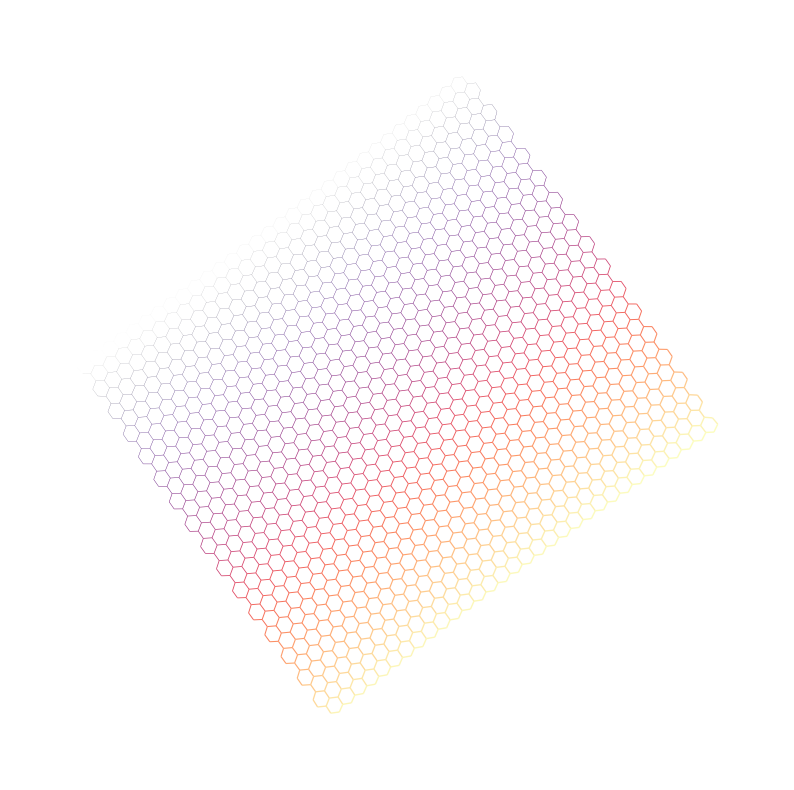

In [156]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

def change_pos(k: np.float64 = 1.0, 
               theta: np.float64 = np.pi/2,
               pos = None):
    warnings.filterwarnings(action='once')
    XY = np.array([v for k, v in pos.items()])
    scale = k
    kXY = scale*XY
    rotation = np.array([
        [np.cos(theta),np.sin(theta)],
        [-np.sin(theta),np.cos(theta)]])
    for i in range(len(pos.items())):
      pos[i] = ((rotation @ kXY[i].flatten()) for i in kXY.flatten())
    return pos

n = 32
I_in = 1000


G = nx.hexagonal_lattice_graph(n, n)
A = np.array(nx.to_pandas_adjacency(G))
k_seed = np.random.random(size=(A.shape[0],A.shape[0]))
I = np.array([I_in] + [-I_in/(A.shape[0]-1) for i in range(A.shape[0]-1)])
k = np.multiply(A, k_seed)
k_sym = (k + k.T)/2
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")

pos = change_pos(k = 100, theta = np.pi/4, pos = pos)

gradient = np.linspace(1,360,len(list(G.nodes())))
weights = np.linspace(0,1,len(list(G.edges)))

nx.set_edge_attributes(G, values = weights, name = 'weight')

fig, ax1 = plt.subplots(1,1,figsize=(10,10))

nx.draw_networkx_edges(
    G = G,
    pos = pos,
    ax = ax1,
    edge_cmap = plt.cm.magma,
    edge_color = weights,
    width = weights)
ax1.axis("off")
plt.show()